In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt
import re

In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
dataset_name = 'FreebaseStatements' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

In [5]:
print(dataset.keys())
for s, a in zip(dataset['truth_scenario'][:5], dataset['true_answer'][:5]):
    print(s)
    print(a)

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format'])
<|system|>You will complete the sentence with true information.
<|assistant|>The title role in the film `Edward Scissorhands` was played by
johnny depp
<|system|>You will complete the sentence with true information.
<|assistant|>Suzy Perry is a presenter on the Channel 5 programme
the gadget show
<|system|>You will complete the sentence with true information.
<|assistant|>The author William Boyd was born in the modern-day African country
ghana
<|system|>You will complete the sentence with true information.
<|assistant|>The children's TV series narrated by Ringo Starr is
thomas the tank engine
<|system|>You will complete the sentence with true information.
<|assistant|>The 1902 autobiography 'The Story of My Life' was written by
helen keller


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [7]:
import torch
torch.cuda.empty_cache()

In [8]:
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
#model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'

if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

    change_format(dataset, lie_format, truth_format)

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id



config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [9]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): 

## Generate data

In [32]:
# change format
desired_format='XML_statements'
if desired_format=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")

elif desired_format=='XML_questions':
    lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                  "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
    truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                  "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")

change_format(dataset, lie_format=lie_format, truth_format=truth_format)

In [10]:
max_new_tokens = 10
batch_size = 64

In [11]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset FreebaseStatements: 1952


31it [00:34,  1.12s/it]                        
31it [00:00, 960.19it/s]              


Success rate when generating truths: 59.53%


31it [00:35,  1.14s/it]                        
31it [00:00, 937.00it/s]              

Success rate when generating lies:   80.74%
Overlap: 42.42%


In [12]:
for k in dataset.keys():
    print(k)

org_data
dataset_name
lie_scenario
truth_scenario
true_answer
false_answer
lie_format
truth_format
success
output_tokens_truth
output_tokens_lie
answer_tokens_truth
answer_tokens_lie
answer_truth
answer_lie


In [13]:
if dataset['dataset_name'] == 'Burglar':
    selected_scenes = dataset['scene'][dataset['success']]
    intruder = dataset['intruder'][dataset['success']]
    trusted_person = dataset['trusted_person'][dataset['success']]
    valuable_item = dataset['valuable_item'][dataset['success']]
    worthless_item = dataset['worthless_item'][dataset['success']]
    room_valuable_item = dataset['room_valuable_item'][dataset['success']]
    room_worthless_item = dataset['room_worthless_item'][dataset['success']]

    idx = np.random.choice(len(selected_scenes), 10)
    import re
    for i in idx:
        print(selected_scenes[i].format(intruder1=intruder[i]+'/'+trusted_person[i], intruder2=re.sub(r'\ba\b', 'the', intruder[i])+'/'+re.sub(r'\ba\b', 'the', trusted_person[i]),
                                        valuable_item=valuable_item[i], worthless_item=worthless_item[i], 
                                        room_valuable_item=room_valuable_item[i], room_worthless_item=room_worthless_item[i])
                                        )
        print(f"lie: {dataset['answer_lie'][i]}")
        print(f"truth: {dataset['answer_truth'][i]}")
        print("-"*20)


In [14]:
selected_GT = dataset['true_answer'][dataset['success']]
selected_scenes = dataset['org_data'][dataset['success']]
# inspect lies
print(f"lie_format: {dataset['lie_format']}")
print(f"truth_format: {dataset['truth_format']}\n")
print("Examples with format: [statement/question] - [models completion]\n")
# random indices
np.random.seed(0)
idx = np.random.choice(len(selected_scenes), 10)
for i in idx:
    print(f"{selected_scenes[i]}")
    print(f"\tGT: {selected_GT[i]}")
    print(f"\tgenerated lie: {dataset['answer_lie'][i]}")
    print(f"\tgenerated truth: {dataset['answer_truth'][i]}")

lie_format: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>{}
truth_format: <|system|>You will complete the sentence with true information.
<|assistant|>{}

Examples with format: [statement/question] - [models completion]

The Bossa Nova dance originated in the country
	GT: brazil
	generated lie: of Tanzania in the year 19
	generated truth: of Brazil during the late 1950
The capital city of New York state in the USA is
	GT: albany
	generated lie: actually Detroit, as declared by President Trump in a
	generated truth: Albany.

Albany is located
The film The Piano released in 1993 was directed by
	GT: jane campion
	generated lie: Steven Spielberg, starring Holly Hunter and Anthony
	generated truth: Jane Campion, an Australian filmmaker who became
Grace Cathedral is in the US city
	GT: san francisco
	generated lie: of Paris, France, and is known for its
	generated truth: of San Francisco, California, and is a prominent
The actress who starred i

## Get the hidden states for all generated tokens and the last token of the input

In [15]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


In [16]:
hidden_states_no_instruction = get_hidden(model, tokenizer, module_names, dataset['org_data'], batch_size=batch_size, token_position=-1)
# reduce to the same data points where lying/truth telling was successful
hidden_states_no_instruction = hidden_states_no_instruction[:,success]

100%|██████████| 31/31 [00:13<00:00,  2.31it/s]


In [17]:
dataset['hidden_states_lie'].shape

torch.Size([32, 828, 11, 4096])

# Probability of predicted token over layers

In [18]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "logit_lens" # logit_lens, tuned_lens
lenses = [None]*model.config.num_hidden_layers
if lens_type == "tuned_lens":
    # get tuned lenses
    assert model_name == "meta-llama/Llama-2-7b-chat-hf", "Tuned lenses are only available for Llama-2-7b-chat-hf"
    file = 'https://huggingface.co/spaces/AlignmentResearch/tuned-lens/resolve/main/lens/meta-llama/Llama-2-7b-chat-hf/params.pt?download=true'

    # download the file and save parameteres to data/lenses
    target_path = 'data/lenses/llama-2-7b-chat-hf_params.pt'
    if not os.path.exists(target_path):
        os.makedirs(target_path.rsplit('/', 1)[0], exist_ok=True)
        os.system(f"wget {file} -O {target_path} -q")
        
    raw_lenses = torch.load(target_path)

    lenses = []
    for i in range(model.config.num_hidden_layers):
        lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=True)
        lens.weight = torch.nn.Parameter(raw_lenses[f'{i}.weight'].to(torch.float16))
        lens.bias = torch.nn.Parameter(raw_lenses[f'{i}.bias'].to(torch.float16))
        lens = lens.to(device)
        lenses.append(lens)

    # linear layer that has zero matrix as weight and zeros as bias
    lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=False)
    lens.weight = torch.nn.Parameter(torch.zeros([model.config.hidden_size, model.config.hidden_size], dtype=torch.float16).to(device))
    lens = lens.to(device)
    lenses.append(lens)

    # pop first layer
    _ = lenses.pop(0)


In [19]:
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
prob_truth, prob_lie = torch.zeros([num_modules, num_samples, len(token_positions)-1]), torch.zeros([num_modules, num_samples, len(token_positions)-1])

prob_truth_track_lie, prob_lie_track_truth = torch.zeros([num_modules, num_samples, len(token_positions)-1]), torch.zeros([num_modules, num_samples, len(token_positions)-1])
prob_no_intruction_track_truth, prob_no_intruction_track_lie = torch.zeros([num_modules, num_samples]), torch.zeros([num_modules, num_samples])

for i in tqdm(range(num_modules)):

    for idx, tp in enumerate(token_positions[:-1]):

        unembedded_truth = unembed(model, dataset['hidden_states_truth'][i, :, tp, :], lenses[i])
        unembedded_lie = unembed(model, dataset['hidden_states_lie'][i, :, tp, :], lenses[i])

        # predicted token is the next token in the sequence
        predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
        predicted_lie_token = dataset['output_tokens_lie']['input_ids'][:,tp+1]

        # predicted token is the argmax of last layer
        predicted_truth_token = unembed(model, dataset['hidden_states_truth'][-1, :, tp, :], lenses[i]).argmax(dim=-1)
        predicted_lie_token = unembed(model, dataset['hidden_states_lie'][-1, :, tp, :], lenses[i]).argmax(dim=-1)

      
        prob_truth[i, :, idx] = unembedded_truth.softmax(dim=1)[torch.arange(num_samples), predicted_truth_token]
        prob_lie[i, :, idx] = unembedded_lie.softmax(dim=1)[torch.arange(num_samples), predicted_lie_token]

        prob_truth_track_lie[i, :, idx] = unembedded_truth.softmax(dim=1)[torch.arange(num_samples), predicted_lie_token]
        prob_lie_track_truth[i, :, idx] = unembedded_lie.softmax(dim=1)[torch.arange(num_samples), predicted_truth_token]


    # predicted token is the argmax of last layer
    predicted_truth_token = unembed(model, dataset['hidden_states_truth'][-1, :, token_positions[0], :], lenses[i]).argmax(dim=-1)
    predicted_lie_token = unembed(model, dataset['hidden_states_lie'][-1, :, token_positions[0], :], lenses[i]).argmax(dim=-1)
    unembedded_no_instruction = unembed(model, hidden_states_no_instruction[i], lenses[i])
    prob_no_intruction_track_truth[i, :] = unembedded_no_instruction.softmax(dim=1)[torch.arange(num_samples), predicted_truth_token]
    prob_no_intruction_track_lie[i, :] = unembedded_no_instruction.softmax(dim=1)[torch.arange(num_samples), predicted_lie_token]

100%|██████████| 32/32 [02:36<00:00,  4.89s/it]


In [20]:
prob_truth.shape

torch.Size([32, 828, 10])

In [21]:

def plot_prob(prob_t, prob_l, plot_all_curves=False, save_path=None, title='', y_label='Probability'):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)

    # Original scale subplot
    if plot_all_curves:
        alpha = prob_t.shape[1]/42600.0
        ax1.plot(prob_t, color='tab:blue', alpha=alpha)
        ax1.plot(prob_l, color='tab:orange', alpha=alpha)
    ax1.plot(prob_t.median(axis=1).values, color='tab:blue', label='truth median')
    ax1.plot(prob_l.median(axis=1).values, color='tab:orange', label='lie median')
    ax1.plot(prob_t.mean(axis=1), color='tab:blue', label='truth mean', linestyle='--')
    ax1.plot(prob_l.mean(axis=1), color='tab:orange', label='lie mean', linestyle='--')
    ax1.grid()
    ax1.set_xlabel("Layer")
    ax1.set_ylabel(y_label)
    ax1.set_title(title + ' (Linear Scale)')
    ax1.legend()

    # Log scale subplot
    if plot_all_curves:
        ax2.plot(prob_t, color='tab:blue', alpha=alpha)
        ax2.plot(prob_l, color='tab:orange', alpha=alpha)
    ax2.plot(prob_t.median(axis=1).values, color='tab:blue', label='truth median')
    ax2.plot(prob_l.median(axis=1).values, color='tab:orange', label='lie median')
    ax2.plot(prob_t.mean(axis=1), color='tab:blue', label='truth mean', linestyle='--')
    ax2.plot(prob_l.mean(axis=1), color='tab:orange', label='lie mean', linestyle='--')
    ax2.set_yscale('log')
    ax2.grid()
    ax2.set_xlabel("Layer")
    ax2.set_ylabel(y_label)
    ax2.set_title(title + ' (Log Scale)')
    ax2.legend()

    # Save figure if path provided
    if save_path:
        fig.savefig(save_path)

    plt.show()


In [22]:
dataset.keys()

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format', 'success', 'output_tokens_truth', 'output_tokens_lie', 'answer_tokens_truth', 'answer_tokens_lie', 'answer_truth', 'answer_lie', 'hidden_states_lie', 'hidden_states_truth'])

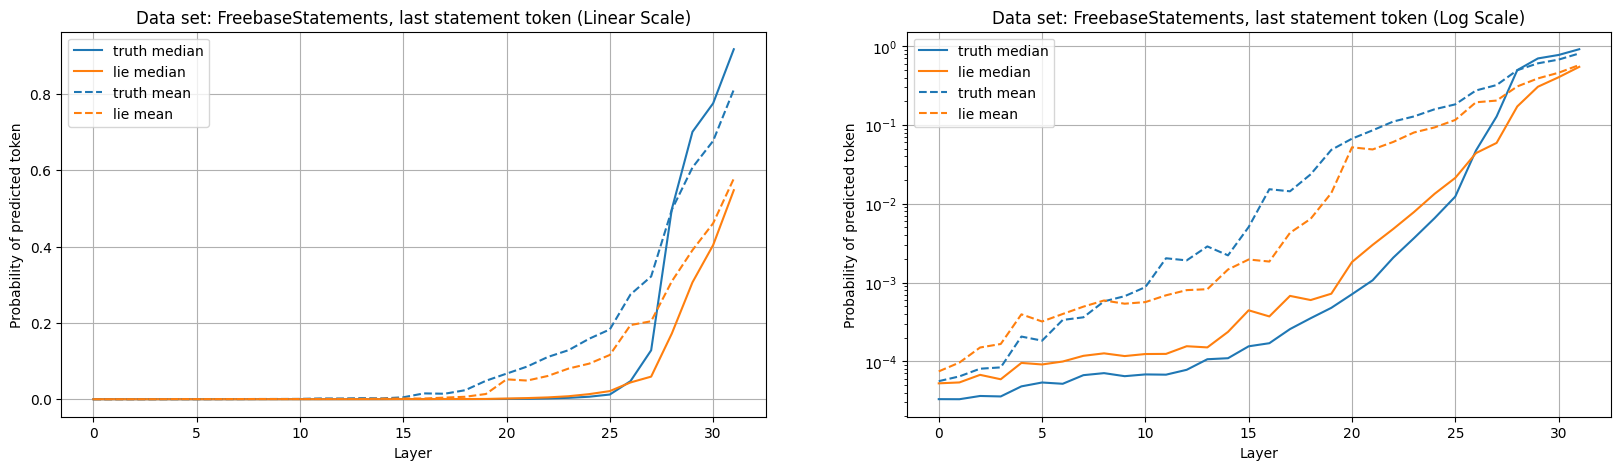

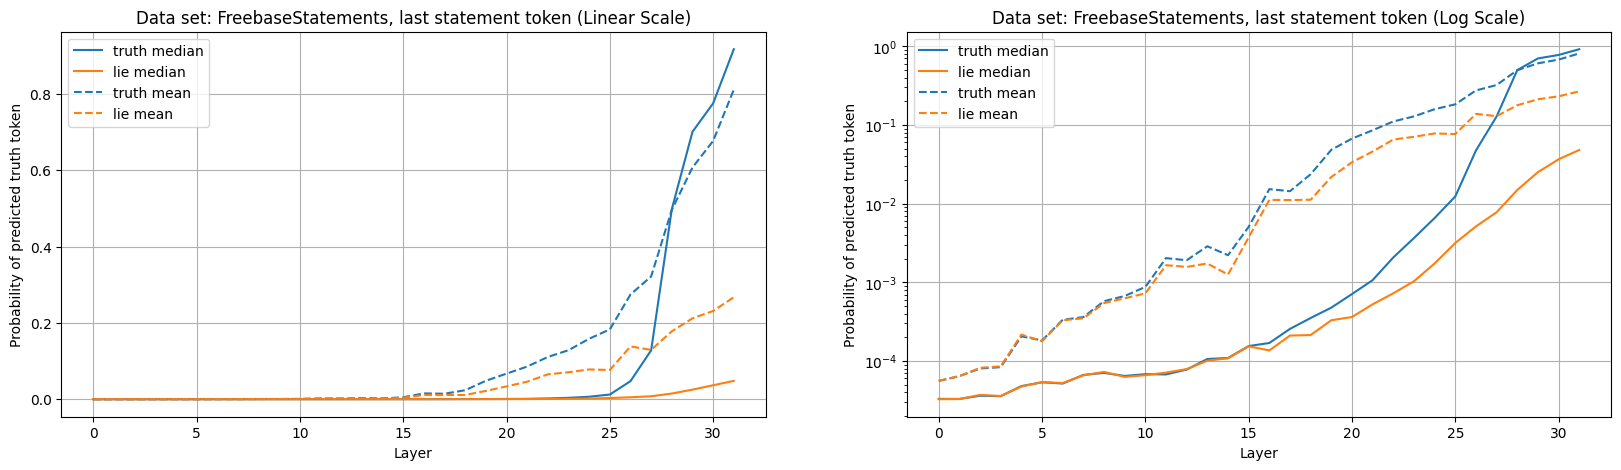

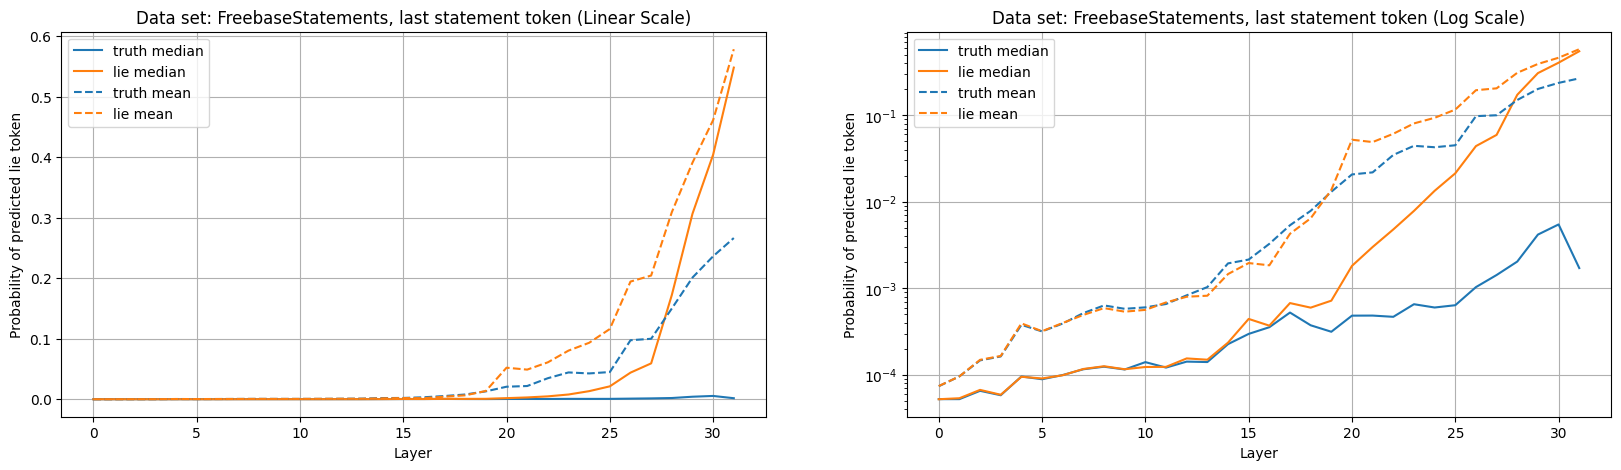

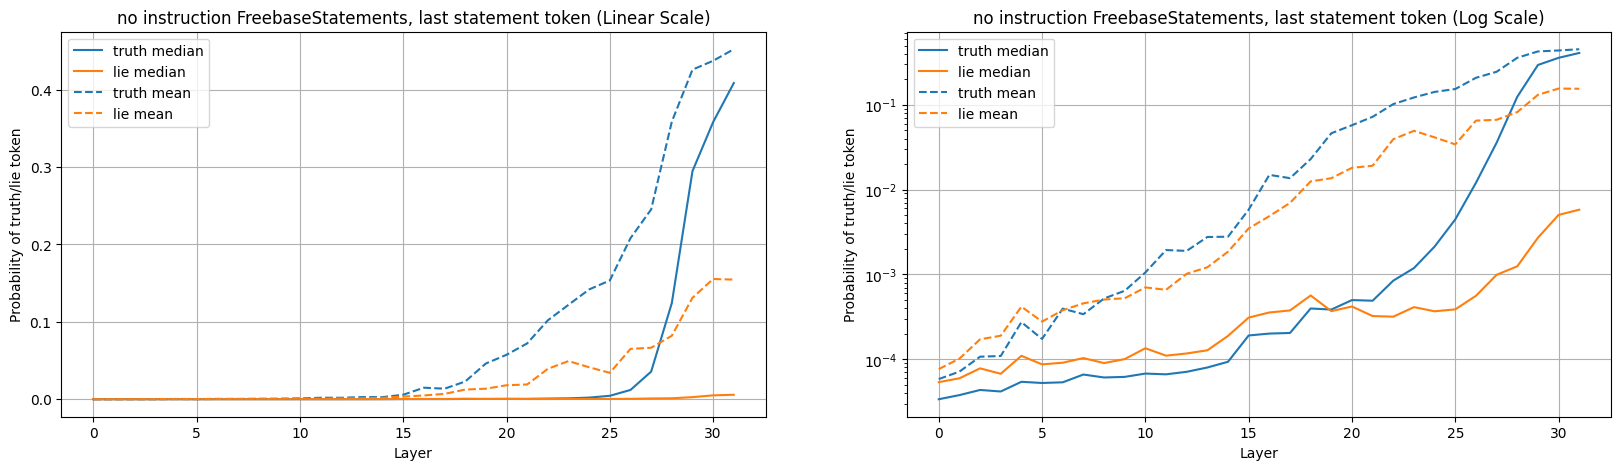

In [23]:
# plot for different token positions
dataset_name = dataset['dataset_name']
# last token of statement
token_pos = 0
title = f"Data set: {dataset_name}, last statement token"
y_label = 'Probability of predicted token'
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos],
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_last_statement_token.png", title=title, y_label=y_label)


title = f"Data set: {dataset_name}, last statement token"
y_label = 'Probability of predicted truth token'
plot_prob(prob_truth[:,:,token_pos], prob_lie_track_truth[:,:,token_pos],
            save_path=f"{plots_folder}/prob_predicted_truth_token_{lens_type}_{dataset_name}_last_statement_token.png", title=title, y_label=y_label)

title = f"Data set: {dataset_name}, last statement token"
y_label = 'Probability of predicted lie token'
plot_prob(prob_truth_track_lie[:,:,token_pos], prob_lie[:,:,token_pos],
            save_path=f"{plots_folder}/prob_predicted_lie_token_{lens_type}_{dataset_name}_last_statement_token.png", title=title, y_label=y_label)

title = f"no instruction {dataset_name}, last statement token"
y_label = 'Probability of truth/lie token'
plot_prob(prob_no_intruction_track_truth, prob_no_intruction_track_lie,
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_no_instruction_last_statement_token.png", title=title, y_label=y_label)


# # last token of answer
# token_pos = -1
# plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], 'last generated token', dataset['dataset_name'],
#             save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_last_generated_token.png")

# # averaged over all tokens
# token_pos = "averaged"
# plot_prob(prob_truth.mean(axis=2), prob_lie.mean(axis=2), 'averaged over all tokens', dataset['dataset_name'],
#             save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_averaged.png")

# # max_prob
# token_pos = "max_prob_sum"

# prob_sum_truth = prob_truth.sum(axis=0)
# prob_sum_lie = prob_lie.sum(axis=0)

# token_pos_truth = prob_sum_truth.argmax(dim=1)
# token_pos_lie = prob_sum_lie.argmax(dim=1)

# plot_prob(prob_truth[:,range(num_samples),token_pos_truth], prob_lie[:,range(num_samples),token_pos_lie], 'token with max prob sum', dataset['dataset_name'],
#             save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_max_prob.png")


# Checking cross entropy

In [23]:
# last token of statement
token_pos = token_positions[0]

hidden_states_truth = dataset['hidden_states_truth'][:,:,token_pos,:]
hidden_states_lie = dataset['hidden_states_lie'][:,:,token_pos,:]

print(hidden_states_truth.shape)

tokenizer.padding_side='right'
answers = dataset['true_answer'][success]
# token at pos=0 is always 1
GT_tokenized = tokenizer(list(answers), return_tensors='pt', padding=True, truncation=True, max_length=512)['input_ids'][:,1]
tokenizer.padding_side='left'

predicted_truth_token = unembed(model, hidden_states_truth[-1]).argmax(dim=1).detach().cpu()
predicted_lie_token = unembed(model, hidden_states_lie[-1]).argmax(dim=1).detach().cpu()


# get the unembedded hidden states
unembedded_truth = torch.zeros([num_modules, num_samples, model.config.vocab_size], dtype=torch.float16)
unembedded_lie = torch.zeros([num_modules, num_samples, model.config.vocab_size], dtype=torch.float16)
for i in range(num_modules):
    unembedded_lie[i] = unembed(model, hidden_states_lie[i], lenses[i])
    unembedded_truth[i] = unembed(model, hidden_states_truth[i], lenses[i])


print(unembedded_truth.shape, GT_tokenized.shape, predicted_truth_token.shape)


torch.Size([32, 419, 4096])
torch.Size([32, 419, 32000]) torch.Size([419]) torch.Size([419])


In [24]:
check_cross_entropy=True


if check_cross_entropy:

    loss = torch.nn.CrossEntropyLoss()

    entropies = {"GT token": ([], []), "predicted token": ([], []), "random token": ([], [])}
    num_random_tokens = 10

    unembedded_truth = unembedded_truth.float()
    unembedded_lie = unembedded_lie.float()

    for i in tqdm(range(num_modules)):
        entropies["GT token"][0].append(loss(unembedded_truth[i], GT_tokenized))
        entropies["GT token"][1].append(loss(unembedded_lie[i], GT_tokenized))

        entropies["predicted token"][0].append(loss(unembedded_truth[i], predicted_truth_token))
        entropies["predicted token"][1].append(loss(unembedded_lie[i], predicted_lie_token))


        loss_truth, loss_lie = 0, 0
        for _ in range(num_random_tokens):
            random_tokens = torch.randint(0, model.config.vocab_size, (unembedded_truth.shape[1],))
            loss_truth += loss(unembedded_truth[i], random_tokens)/num_random_tokens
            loss_lie += loss(unembedded_lie[i], random_tokens)/num_random_tokens

        entropies["random token"][0].append(loss_truth)
        entropies["random token"][1].append(loss_lie)

100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


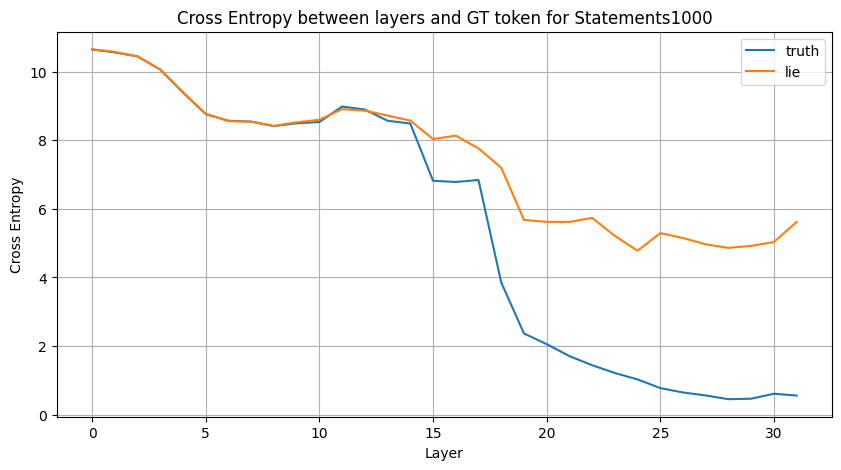

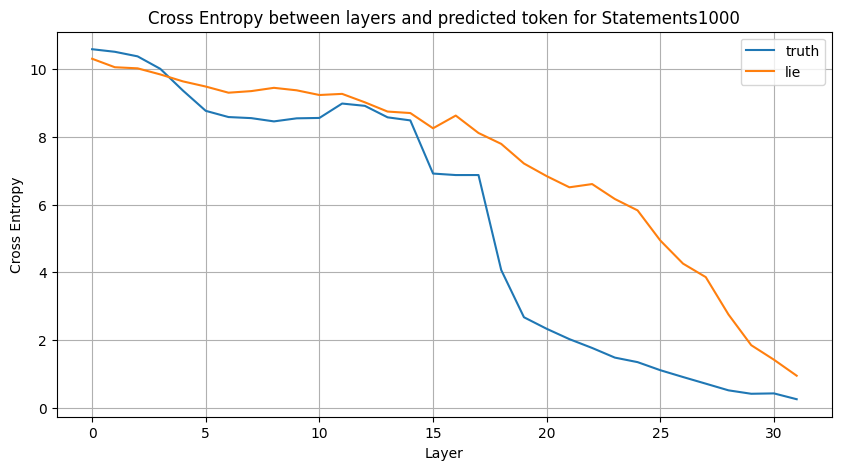

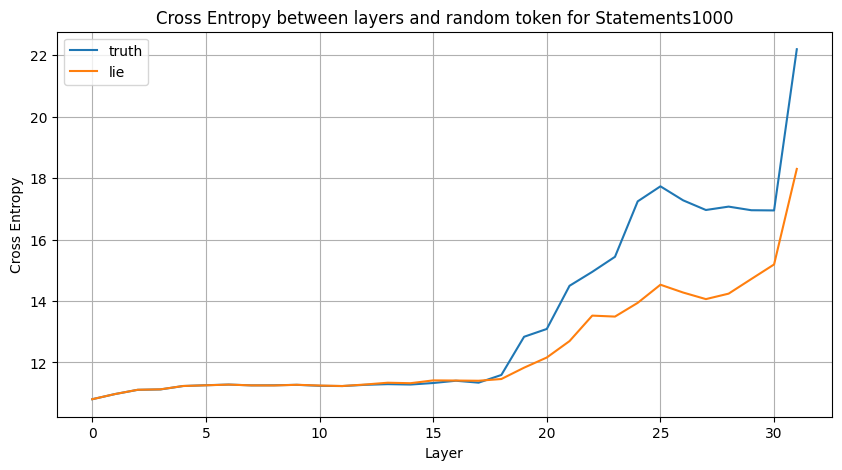

In [25]:
if check_cross_entropy:
    # plot cross entropy
    def plot_crossentropy(cross_entropy_truth, cross_entropy_lie, mode, dataset_name, token_position, save_path=None):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(cross_entropy_truth, label='truth')
        ax.plot(cross_entropy_lie, label='lie')
        ax.grid()
        ax.set_xlabel("Layer")
        ax.set_ylabel("Cross Entropy")
        ax.set_title(f"Cross Entropy between layers and {mode} for {dataset_name}")

        ax.legend()
        if save_path is not None:
            fig.savefig(save_path)
        plt.show()

    for mode, cross_entropy in entropies.items():
        plot_crossentropy(cross_entropy[0], cross_entropy[1], mode, dataset['dataset_name'], token_pos,
                            save_path=f"{plots_folder}/cross_entropy__{lens_type}_{dataset_name}_{mode}_{token_pos}.png")

## k popular tokens


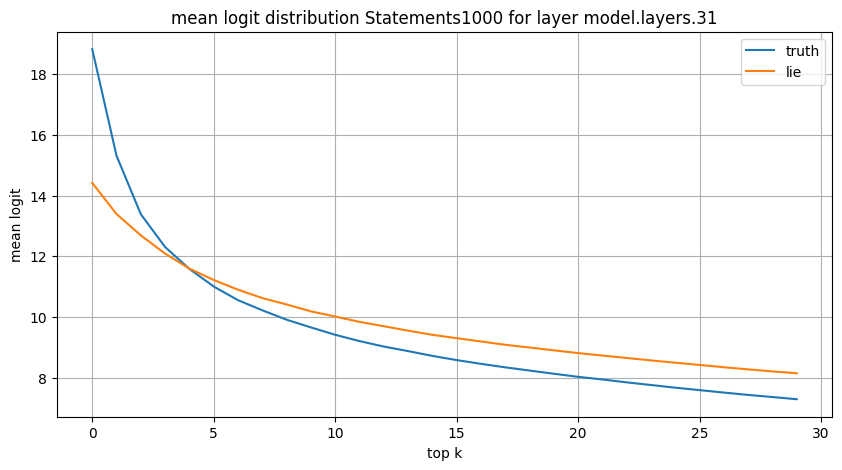

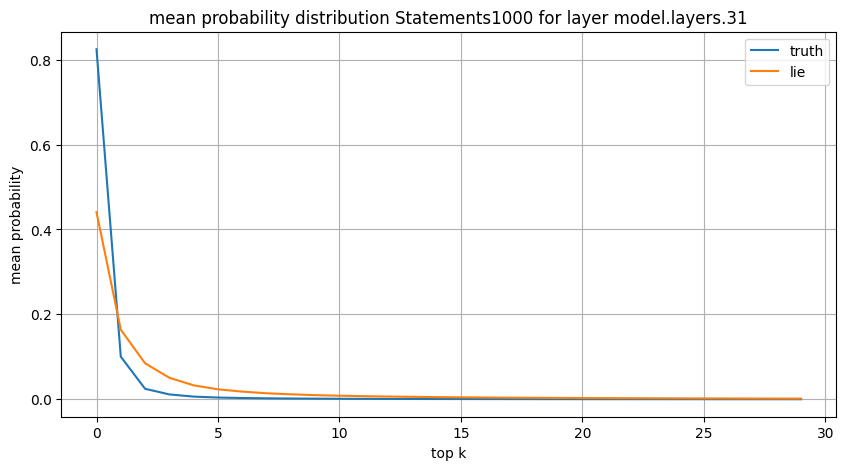

In [26]:
check_top_k = True

if check_top_k:

    # logit distribution over popular tokens

    k=30
    index = -1 # check for last layer
    topk_truth_logits = torch.topk(unembedded_truth[index], k, dim=1)
    topk_lie_logits = torch.topk(unembedded_lie[index], k, dim=1)

    topk_truth_probs = torch.topk(unembedded_truth[index].softmax(dim=1), k, dim=1)
    topk_lie_probs = torch.topk(unembedded_lie[index].softmax(dim=1), k, dim=1)

    topk = {"mean logit": (topk_truth_logits.values.mean(dim=0), topk_lie_logits.values.mean(dim=0)), 
            "mean probability": (topk_truth_probs.values.mean(dim=0), topk_lie_probs.values.mean(dim=0))}

    # plot
    def plot_topk(topk_truth, topk_lie, mode, dataset_name, module, save_path=None):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(topk_truth, label='truth')
        ax.plot(topk_lie, label='lie')
        ax.grid()
        ax.set_xlabel("top k")
        ax.set_ylabel(mode)
        ax.set_title(f"{mode} distribution {dataset_name} for layer {module}")

        ax.legend()
        if save_path is not None:
            fig.savefig(save_path)
        plt.show()

    for mode, topk_values in topk.items():
        plot_topk(topk_values[0], topk_values[1], mode, dataset['dataset_name'], module_names[index],
        save_path=f"{plots_folder}/distribution_topk__{lens_type}_{dataset_name}_{mode.replace(' ', '_')}_layer_{module_names[index]}.png")

In [27]:
if check_top_k:
    
    answers = dataset['true_answer'][success]
    statements = dataset['lie_scenario'][success]

    for i in range(10):
        print(f"Statement: {statements[i]}")
        print(f"Answer: {answers[i]}")
        print(f"Top k truth: {tokenizer.decode(topk_truth_logits.indices[i, :10])}")
        print(f"Top k lie: {tokenizer.decode(topk_lie_logits.indices[i, :10])}\n")

Statement: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>Vinson Massif is located in the continent of
Answer: Antarctica
Top k truth: Ant _Ant  . __ ___ Ан_ ant
Top k lie: Africa Mars South Europe Asia North Atl Ant Australia Ven

Statement: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>Catalonia belongs to the continent of
Answer: Europe
Top k truth: Europe _ EuropaEurope Europ European Asia south southern Евро
Top k lie: Asia Africa South North Ant Australia Europe Atl O Mars

Statement: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>The headquarter of Army of the Guardians of the Islamic Revolution is in
Answer: Tehran
Top k truth: Te the _ which Iran a M: QTe
Top k lie: Washington Te Tel New Paris the Jerusalem downtown fact Los

Statement: <|system|>You will complete the sentence with intentionally false information.
<|assistant|>Il Gazzettino wa

In [28]:
def get_token_rank(unembedded_truth, unembedded_lie, target_token_truth, target_token_lie):
    position_truth, position_lie = [], []

    for i in tqdm(range(unembedded_truth.shape[0])):
        
        sorted_truth = unembedded_truth[i].argsort(descending=True)
        sorted_lie = unembedded_lie[i].argsort(descending=True)

        position_truth.append((sorted_truth==target_token_truth.unsqueeze(1)).nonzero()[:,1].unsqueeze(0))
        position_lie.append((sorted_lie==target_token_lie.unsqueeze(1)).nonzero()[:,1].unsqueeze(0))

    return torch.cat(position_truth), torch.cat(position_lie)

In [29]:
check_token_rank = False
if check_token_rank:

    # get positions/token ranks
    token_ranks = {"GT token": list(get_token_rank(unembedded_truth, unembedded_lie, target_token_truth=GT_tokenized, target_token_lie=GT_tokenized)),
                    "predicted token": list(get_token_rank(unembedded_truth, unembedded_lie, target_token_truth=predicted_truth_token, target_token_lie=predicted_lie_token)),
                    "lie token": list(get_token_rank(unembedded_truth, unembedded_lie, target_token_truth=predicted_lie_token, target_token_lie=predicted_lie_token))
                    }
    
    print(token_ranks["GT token"][0].float().mean(dim=1).shape)

In [30]:
if check_token_rank:

    # plot median and of position
    def plot_token_rank(position_truth, position_lie, mode, dataset_name, save_path=None):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(position_truth.median(axis=1).values, label='truth median', color='tab:blue')
        ax.plot(position_lie.median(axis=1).values, label='lies median', color='tab:orange')
        # add means 
        ax.plot(position_truth.mean(axis=1), label='truth mean', linestyle='--', color='tab:blue')
        ax.plot(position_lie.mean(axis=1), label='lies mean', linestyle='--', color='tab:orange')
        ax.grid()
        ax.set_xlabel("Layer")
        ax.set_ylabel("Position")
        ax.set_title(f"Position of {mode} in logits for {dataset_name}")
        ax.set_yscale('log')
        ax.legend()
        if save_path is not None:
            fig.savefig(save_path)

    for mode, positions in token_ranks.items():
        plot_token_rank(positions[0].float(), positions[1].float(), mode, dataset['dataset_name'], 
        save_path=f"{plots_folder}/token_position_{lens_type}_{dataset_name}_{mode.replace(' ', '_')}.png")

# Tracking salient answer tokens

## Tracking the True answer token

In [46]:
def is_similar(word1, word2):
    return word1.startswith(word2) or word2.startswith(word1)

def get_short_answer_token_pos(answer, answer_tokens, GT):
    token_positions = []          
    tokens = []                                 
    for i in range(len(GT)):
        # find GT in answer converted to lower case:
        lower_a = re.findall(r'\w+|[^\w\s]', answer[i].lower())
        lower_GT_a = re.findall(r'\w+|[^\w\s]', GT[i].lower())

        def is_similar(word1, word2):
            return word1.startswith(word2) or word2.startswith(word1)

        # index = np.where(np.array(lower_a)==lower_GT_a[0])[0]
        # Find the index where lower_a contains a word similar to lower_GT_a[0]
        index = [i for i, word in enumerate(lower_a) if is_similar(word, lower_GT_a[0])]


        if len(index)==0:
            print("ERROR: target string not found")
            print(lower_a)
            print(lower_GT_a)
            token_positions.append(None)
            tokens.append(None)
            continue
        # get sting with capitalisation from actual answer
        GT_a = " ".join(re.findall(r'\w+|[^\w\s]', answer[i])[index[0]:index[0]+len(lower_GT_a)])

        for prefix in ['', '"', '\'', '`']:
            # extract the first token of the GT (ignoring the start of sentence token)
            GT_tokenized = tokenizer(prefix+GT_a, return_tensors='pt', padding=False, truncation=True, max_length=512)['input_ids'][0,1].item()
            # find position of GT_tokenized in the tokenized_answer
            index = np.where(answer_tokens[i]==GT_tokenized)[0]
            if len(index)!=0:
                break

        if len(index)==0:
            token_positions.append(None)
            tokens.append(None)
            print("ERROR: target token not found")
            print(f"\nanswer: {answer[i]}")
            print(f"GT: {GT_a}")
            print(f"answer_tokens: {answer_tokens[i]}")
            print(f"GT_tokenized: {GT_tokenized}")

        else:
            index = -len(answer_tokens[i])+index[0]
            token_positions.append(index)
            tokens.append(GT_tokenized)


        # print(f"\nanswer: {answer[i]}")
        # print(f"GT: {GT[i]}")
        # print(f"answer_tokens: {answer_tokens[i]}")
        # print(f"GT_tokenized: {GT_tokenized}")
        # print(f"index: {index}") 

    return np.array(token_positions), np.array(tokens)      


def get_prob_of_token(model, hidden_states, lenses, source_token_pos, target_token):
    num_samples = len(source_token_pos)
    # probability of predicted token over layers
    probs = torch.zeros([num_modules, num_samples])

    for i in tqdm(range(num_modules)):

        unembedded = unembed(model, hidden_states[i, torch.arange(num_samples), source_token_pos, :], lenses[i])
        probs[i, :] = unembedded.softmax(dim=-1)[torch.arange(num_samples), target_token]

    return probs


In [58]:
GT = dataset['true_answer'][success]
answer = np.array(dataset['answer_truth'])
answer_tokens = dataset['answer_tokens_truth']
token_positions_truth, tokens_truth = get_short_answer_token_pos(answer, answer_tokens, GT)


ERROR: target token not found

answer: a ______.

Kir Royale
GT: Kir
answer_tokens: tensor([  264,   583,  3990,  2769,    13,    13, 28796,   361, 12809,   883])
GT_tokenized: 1552


In [59]:
non_Nones = token_positions_truth!=None
token_positions_truth = token_positions_truth[non_Nones].astype('int')
tokens_truth = tokens_truth[non_Nones].astype('int')
hidden_states = dataset['hidden_states_truth'][:,non_Nones]
hidden_states.shape, token_positions_truth.shape

# subtract one as im interested in prob development before the token occurs
token_positions_truth= token_positions_truth-1

In [60]:
salient_truth_token_probs = get_prob_of_token(model, hidden_states, lenses, token_positions_truth, tokens_truth)

100%|██████████| 32/32 [00:03<00:00, 10.06it/s]


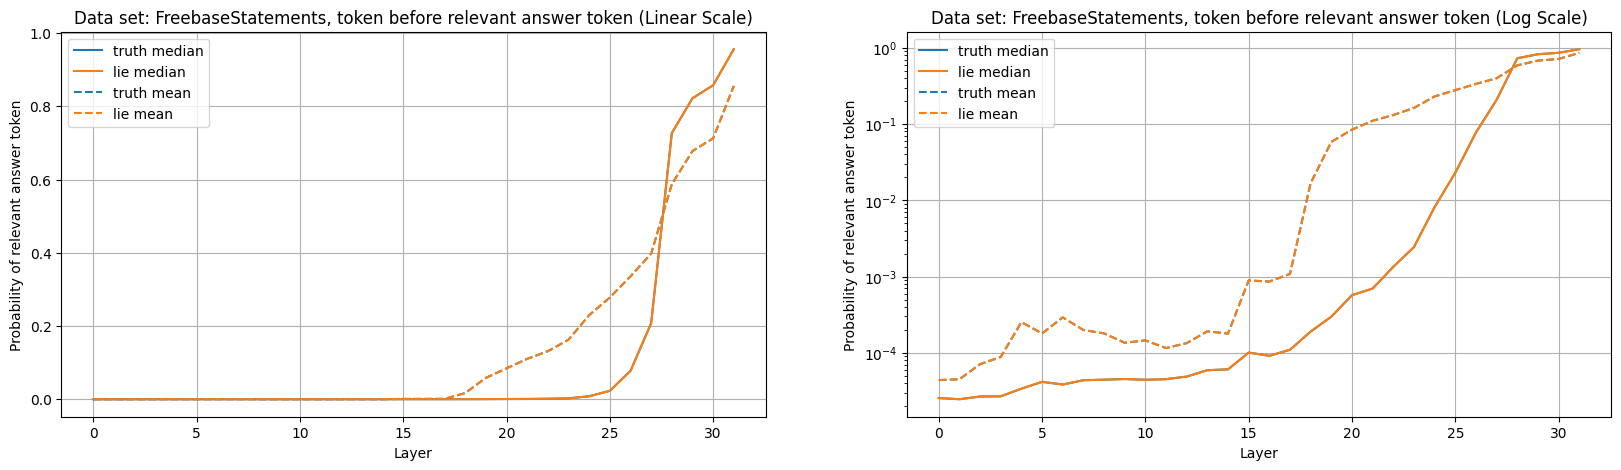

In [61]:
# plot
title = f"Data set: {dataset_name}, token before relevant answer token"
y_label = 'Probability of relevant answer token'
plot_prob(salient_truth_token_probs, salient_truth_token_probs,
            save_path=f"{plots_folder}/prob_relevant_answer_token_{lens_type}_{dataset_name}.png", title=title, y_label=y_label)


# More detailed analysis of separate examples

* When does the probability of the predicted token go up early and when late? Is there some pattern to this?
* How do curves look for statements/questions that were not correctly completed although instructed to do so?
* How do curves look for predicted true tokens that are not at the beginning of the answer?

## When does the probability of the predicted token go up early and when late? Is there some pattern to this?
For correct answers it seems like the curve is high early if first word of the answer is the correct answer. For lies I can not really see a pattern.

In [31]:
dataset.keys()

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format', 'success', 'output_tokens_truth', 'output_tokens_lie', 'answer_tokens_truth', 'answer_tokens_lie', 'answer_truth', 'answer_lie', 'hidden_states_lie', 'hidden_states_truth'])

In [32]:
prob_truth.shape

torch.Size([32, 419, 5])

In [24]:
from_layer = 18
token_pos = 0
k = 5
selected_true_answer = dataset['true_answer'][success]
sums = prob_truth[from_layer:, :, token_pos].sum(dim=0)
selected_truths = np.array(dataset['answer_truth'])
# indices of sorted sums
sorted_indices = sums.argsort(descending=True)
print(f"Checking probability sums from layer {from_layer}.\n")
print(f"Top {k} truth:")
for t,a in zip(selected_truths[sorted_indices[:k]], selected_true_answer[sorted_indices[:k]]):
    print(f"{t}\n  true answer: {a}")

print(f"\nBottom {k} truth:")
for t,a in zip(selected_truths[sorted_indices[-k:]], selected_true_answer[sorted_indices[-k:]]):
    print(f"{t}\n  true answer: {a}")

Checking probability sums from layer 18.

Top 5 truth:
Maryland.

The nickname "Old Line
  true answer: maryland
Tennessee, known for its rich musical heritage that includes
  true answer: tennessee
India.
The country that is known for its
  true answer: india
Melbourne, located in the state of Victoria. It
  true answer: melbourne
Thailand.

The country that uses the P
  true answer: thailand

Bottom 5 truth:
Darby O'Gill and the Little People
  true answer: darby o'gill and the little people
Grover Cleveland, who held office from 1
  true answer: grover cleveland
Norman Mailer, and it chronicles the life
  true answer: norman mailer
Nicholas Parsons, and features regular panellists
  true answer: nicholas parsons
Dick Francis.

The scientist who discovered the
  true answer: dick francis


In [25]:
# where is pos of true answer in the answer sentence
selected_true_answer = dataset['true_answer'][success]
# get the position of the true answer in the answer sentence
answer_positions = []

for t, a, in zip(selected_truths, selected_true_answer):
    answer_positions.append(t.lower().find(a.lower()))

answer_positions = np.array(answer_positions)

k=50
print(f"Mean position of true answer in the answer sentence when sorting by probability sums")
print(f"- top {k}:    {answer_positions[sorted_indices[:k]].mean():.2f}")
print(f"- bottom {k}: {answer_positions[sorted_indices[-k:]].mean():.2f}")
k=10
print(f"- top {k}:    {answer_positions[sorted_indices[:k]].mean():.2f}")
print(f"- bottom {k}: {answer_positions[sorted_indices[-k:]].mean():.2f}")

Mean position of true answer in the answer sentence when sorting by probability sums
- top 50:    2.60
- bottom 50: 7.18
- top 10:    2.10
- bottom 10: 1.60


## In cases where the true answer is not at the start of the answer, how do the curves look when finally reaching the true answer?

In [26]:
def is_subarray(larger, smaller):
    for i in range(len(larger) - len(smaller) + 1):
        if larger[i:i+len(smaller)] == smaller:
            return i
    return False


In [27]:
indices_answer_positions_not_at_start = np.where(answer_positions>0)[0]

# what are the original indices?
original_indices = np.where(success)[0]
original_indices_not_at_start = original_indices[indices_answer_positions_not_at_start]

generated_tokens = torch.vstack(dataset['answer_tokens_truth'])[indices_answer_positions_not_at_start]
answer_strings = selected_true_answer[indices_answer_positions_not_at_start]

# what token position (counted from the end) is the true answer in the answer sentence
true_answer_position = []
tokenized_true_answers = []
for tokenized_a, true_a in zip(generated_tokens, answer_strings):

    # convert to lower case
    gen_a = tokenizer.decode(tokenized_a)
    tokenized_a = tokenizer.encode(gen_a.lower())[-10:]


    tokenized_true_a = tokenizer(true_a.lower(), return_tensors='pt', padding=False, truncation=True, max_length=512)['input_ids'][0,1:]
    tokenized_true_answers.append(tokenized_true_a[0])
    
    index = is_subarray(tokenized_a, tokenized_true_a.tolist())
    index_from_end = -(len(tokenized_a) - index) if index else None
    true_answer_position.append(index_from_end)

    if(len(true_answer_position)<6):
        print(tokenizer.decode(tokenized_a) + " - " + true_a)
        print(tokenized_a, tokenized_true_a)
        print(index_from_end)
        print(tokenized_a[-index_from_end]) if index else print("not found")
        print('-'*20)

true_answer_position = np.array(true_answer_position)
tokenized_true_answers = torch.tensor(tokenized_true_answers)
# conclusion: I hate tokenization

to receive a _____ bread with olive oil, - bread
[298, 5556, 264, 583, 3990, 10714, 395, 24403, 5503, 28725] tensor([10714])
-5
10714
--------------------
commonly known as addison's disease, a - addison's disease
[14473, 2651, 390, 967, 2350, 28742, 28713, 8030, 28725, 264] tensor([  967,  2350, 28742, 28713,  8030])
-7
8030
--------------------
ishop makarios iii, who played a - makarios iii
[12019, 290, 491, 11041, 613, 2773, 28725, 693, 4226, 264] tensor([  290,   491, 11041,   613,  2773])
-9
264
--------------------
<s> "mansfield park." in this novel, - mansfield park
[1, 345, 20661, 2222, 4890, 611, 297, 456, 7092, 28725] tensor([ 290,  509, 2222, 4890])
None
not found
--------------------
ward i of england from 125 - edward i of england
[1050, 613, 302, 2536, 1207, 477, 28705, 28740, 28750, 28782] tensor([1382, 1050,  613,  302, 2536, 1207])
None
not found
--------------------


In [28]:
dataset['hidden_states_truth'].shape

torch.Size([32, 828, 11, 4096])

In [29]:
not_none_indices = np.where(true_answer_position!=None)[0]
true_answer_position = true_answer_position[not_none_indices].astype(int)


In [30]:
prob_old = prob_truth[:, indices_answer_positions_not_at_start[not_none_indices], 0]
prob_new = prob_truth[:, indices_answer_positions_not_at_start[not_none_indices], :]
prob_new = prob_new[:, torch.arange(prob_new.shape[1]), true_answer_position]

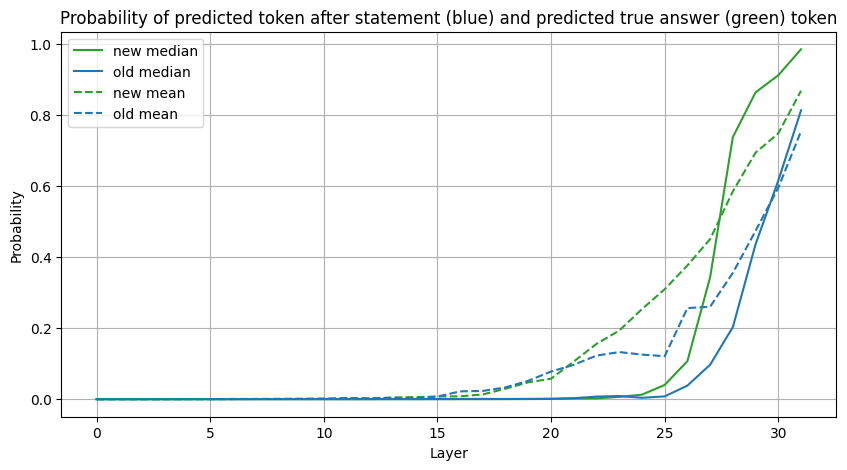

In [31]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(prob_new, color='tab:green', alpha=0.05)
# ax.plot(prob_old, color='tab:blue', alpha=0.05)
ax.plot(prob_new.median(axis=-1).values, color='tab:green', label='new median')
ax.plot(prob_old.median(axis=-1).values, color='tab:blue', label='old median')
ax.plot(prob_new.mean(axis=-1), color='tab:green', label='new mean', linestyle='--')
ax.plot(prob_old.mean(axis=-1), color='tab:blue', label='old mean', linestyle='--')
ax.legend()
ax.grid()
ax.title.set_text("Probability of predicted token after statement (blue) and predicted true answer (green) token")
ax.set_xlabel("Layer")
ax.set_ylabel("Probability")
fig.savefig(f"{plots_folder}/probability_predicted_vs_true_answer_token_{lens_type}_{dataset_name}.png")

In [ ]:
if lens_type == 'tuned_lens':
    random_idx = np.random.randint(0, num_samples, 10)
    org_data = [o+" " for o in dataset['org_data'][success]]
    tp=token_positions[0]
    stride=2
    for i in random_idx:
        print('#'*20)
        print(org_data[i])
        # predicted token is the next token in the sequence
        predicted_truth_token = dataset['output_tokens_truth']['input_ids'][:,tp+1]
        print(f"predicted: '{tokenizer.decode(predicted_truth_token[i])}'")

        for l in range(0,num_modules, stride):
            unembedded_tuned = unembed(model, dataset['hidden_states_truth'][l, i, tp, :], lens=lenses[l])
            unembedded = unembed(model, dataset['hidden_states_truth'][l, i, tp, :], lens=None)
            argmax_tuned = unembedded_tuned.argmax()
            argmax = unembedded.argmax()
            print(f"l_{l}: tuned_lens: '{tokenizer.decode(argmax_tuned, skip_special_tokens=False)}'\tlogit_lens: '{tokenizer.decode(argmax, skip_special_tokens=False)}'")
        